# ImageNet Fine Tuning Binary
This experiment will involve fine-tuning a pretrained Xception model in an attempt to improve image quality classification. The images will be resized to 128x128, and the labels will be transformed from multiclass to binary labels, labeling 1s and 2s as high-quality (1) and 3s as low-quality (0). The model will be fit onto the data and fine-tuned, incrementally unfreezing top layers for closer fine-tuning.

In [1]:
!nvidia-smi

Fri Aug  9 22:58:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   30C    P0             39W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-08-09 22:58:52.002492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 22:58:52.019453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 22:58:52.037394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 22:58:52.042747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 22:58:52.055214: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [6]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time

In [7]:
!pwd
!ls koa_scratch

/home/jctactay
images


In [8]:
imgs = {}
t0 = time()
home = "/home/jctactay/koa_scratch/images"

for i in os.listdir(home):
    img_path = os.path.join(home, i)
    img = Image.open(img_path)
    img = img.resize((128,128))
    np_img = np.array(img)/255
    imgs[i] = np_img
print(f"Done in {time() - t0: .3f}s")

Done in  464.539s


In [49]:
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [50]:
print(len(imgs))

3613


In [51]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [52]:
labels.quality.value_counts()

quality
2    1479
1    1116
3     991
Name: count, dtype: int64

In [53]:
for index, row in labels.iterrows():
    if row.quality == 2:
        labels.at[index, 'quality'] = 1
    if row.quality == 3:
        labels.at[index, 'quality'] = 0
labels.quality.value_counts()

quality
1    2595
0     991
Name: count, dtype: int64

In [54]:
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [55]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           0  
1           1  
2           1  
3          

In [56]:
Y = labels.quality
# print
# for i in range(len(Y)):
#     Y.iat[i] -= 1
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

3586
3586
[1.80756303 0.69119537]


{0: 1.807563025210084, 1: 0.6911953727506427}

In [125]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

In [143]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(2048)(x)
x = keras.layers.Dropout(0.35)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_14 (InputLayer) │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_8  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_13 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 4,752,897 (18.13 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

In [127]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [128]:
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

In [129]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

In [130]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# class_weight does not seem to be working
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), callbacks=callback)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.6490 - loss: 0.7020 - val_accuracy: 0.7545 - val_loss: 0.5514
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7634 - loss: 0.5167 - val_accuracy: 0.7587 - val_loss: 0.5076
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7577 - loss: 0.5130 - val_accuracy: 0.7531 - val_loss: 0.5098
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7714 - loss: 0.5130 - val_accuracy: 0.7559 - val_loss: 0.4967
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7693 - loss: 0.4810 - val_accuracy: 0.7643 - val_loss: 0.4865
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7708 - loss: 0.4826 - val_accuracy: 0.7545 - val_loss: 0.4925
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7803 - loss: 0.4673 - val_accuracy: 0.7657 - val_loss: 0.4849
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7956 - loss: 0.4651 - val_accuracy: 0.7503 -

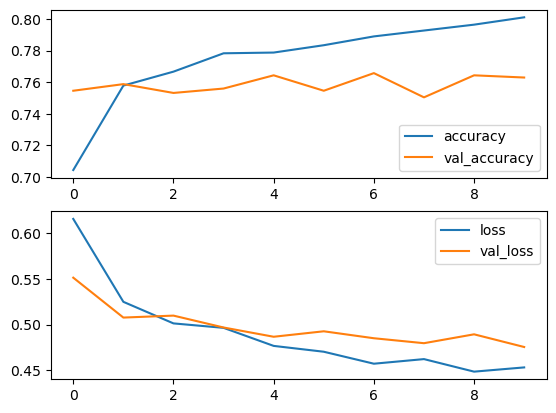

In [132]:
plot_history(history)

In [133]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7889 - loss: 0.4659
test loss, test acc: [0.47359389066696167, 0.7799443006515503]


In [134]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_13 (InputLayer) │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_7  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_7 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_12 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 3,165,697 (12.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 4,100 (16.02 KB)

In [135]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [136]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

epochs=20
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7472 - loss: 0.5370 - precision: 0.8862 - val_accuracy: 0.7587 - val_loss: 0.4785 - val_precision: 0.7772
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7788 - loss: 0.5099 - precision: 0.8661 - val_accuracy: 0.7643 - val_loss: 0.4825 - val_precision: 0.7804
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8073 - loss: 0.4734 - precision: 0.8608 - val_accuracy: 0.7629 - val_loss: 0.4851 - val_precision: 0.7801
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8340 - loss: 0.4536 - precision: 0.8695 - val_accuracy: 0.7629 - val_loss: 0.4852 - val_precision: 0.7801
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8308 - loss: 0.4362 - precision: 0.8517 - val_accuracy: 0.7573 - val_loss: 0.4861 - val_precision: 0.7787
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8264 - loss: 0.4355 - precision: 0.8450 - val_accuracy: 0.7601 - val_loss: 0.

In [137]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'val_accuracy', 'val_loss', 'val_precision'])


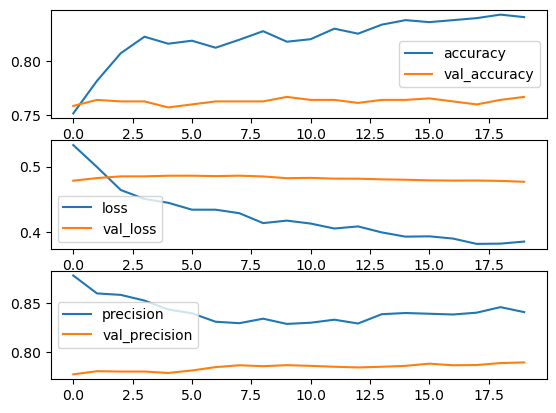

In [138]:
plot_history(history)

In [139]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc, test prec:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7747 - loss: 0.4765 - precision: 0.8059
test loss, test acc, test prec: [0.47996947169303894, 0.777158796787262, 0.8030303120613098]


In [145]:
# unfreeze 4 more base layers
for layer in base_model.layers[-8:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_14 (InputLayer) │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_8  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_13 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 4,752,897 (18.13 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

In [148]:
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

epochs=30
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.7508 - loss: 0.5560 - precision: 0.7545 - val_accuracy: 0.7420 - val_loss: 0.5529 - val_precision: 0.7463
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7260 - loss: 0.5450 - precision: 0.7314 - val_accuracy: 0.7448 - val_loss: 0.5433 - val_precision: 0.7493
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7749 - loss: 0.5138 - precision: 0.7758 - val_accuracy: 0.7490 - val_loss: 0.5352 - val_precision: 0.7519
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7527 - loss: 0.5227 - precision: 0.7518 - val_accuracy: 0.7517 - val_loss: 0.5277 - val_precision: 0.7541
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7647 - loss: 0.5121 - precision: 0.7687 - val_accuracy: 0.7503 - val_loss: 0.5211 - val_precision: 0.7545
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7789 - loss: 0.4898 - precision: 0.7810 - val_accuracy: 0.7476 - val_loss: 0.

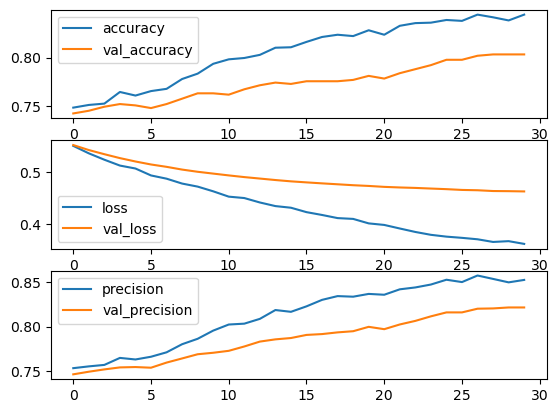

In [149]:
plot_history(history)

In [150]:
results = model.evaluate(X_test, Y_test)
results

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8044 - loss: 0.4426 - precision: 0.8351


[0.44044965505599976, 0.7896935939788818, 0.8219895362854004]